In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import time
import math

%matplotlib inline

In [2]:
data = pd.read_csv('./data/datathon.csv')
data[:10]

,Unnamed: 0,time,refID_coin,price,marketCap,CirculatingSupply,Volume24h,Movement1h,Movement24h
0,0,2018-01-17 11:25:00,1442,10756.000000,180786170372,16807937,17884600000,-1.42,-11.40
1,1,2018-01-17 11:25:00,1443,960.930000,93242345727,97033038,7990730000,-2.37,-12.48
2,2,2018-01-17 11:25:00,1444,1.130000,43630734374,38739142811,6058320000,-3.03,-18.17
3,3,2018-01-17 11:25:00,1445,1744.130000,29504008303,16916175,1544790000,-3.20,-12.15
4,4,2018-01-17 11:25:00,1446,0.544258,14111015557,25927070538,1511130000,-2.56,-14.91
5,5,2018-01-17 11:25:00,1448,176.140000,9651298201,54793958,1353810000,-1.36,-12.67
6,6,2018-01-17 11:25:00,1447,0.887129,7984160999,8999999999,174228000,-0.79,-20.52
7,7,2018-01-17 11:25:00,1449,119.860000,7791225000,65000000,1366290000,-3.92,-21.24
8,8,2018-01-17 11:25:00,1450,0.411229,7357217335,17890803748,443714000,-1.09,-14.33
9,9,2018-01-17 11:25:00,1451,2.480000,6905187082,2779530283,245908000,-1.79,-16.55


In [19]:
data = data[data['refID_coin'] == 1442]
# data = data.set_index('time')
data[:10]

train = data[['price', 'marketCap', 'Volume24h', 'Movement1h', 'Movement24h']]
train[:10]

,price,marketCap,Volume24h,Movement1h,Movement24h
0,10756.0,180786170372,17884600000,-1.42,-11.40
1442,10788.1,181325705150,17865300000,-1.08,-10.91
2884,10807.5,181651779128,17891800000,-0.65,-10.75
4326,10776.1,181124548711,17712000000,-1.13,-10.58
5768,10729.7,180344658114,17645700000,-1.52,-10.74
7210,10653.3,179060527907,17405300000,-2.40,-11.37
8652,10529.0,176971295123,17049000000,-3.48,-12.34
10094,10457.1,175763062285,16945500000,-3.77,-12.80
11536,10492.2,176353023506,17028500000,-3.00,-12.55
12978,10465.7,175907611188,16881000000,-3.08,-12.75


In [36]:
def get_series(data, history_size, output_size=1, y_column=0):
    features = 1 if type(data) is list else data.shape[1]
    rows = len(data) if type(data) is list else data.shape[0]

    df = pd.DataFrame(data)
    frames_X = np.zeros([rows - history_size, history_size, features])
    frames_Y = np.zeros([rows - history_size, output_size])

    for timeframe in range(rows - history_size - output_size):
        frames_X[timeframe] = df[timeframe: timeframe + history_size]
        frames_Y[timeframe] = df[timeframe + history_size : timeframe + history_size + output_size][y_column]

    return frames_X, frames_Y

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)

In [37]:
series_X, series_Y = get_series(train, 20)

In [38]:
series_X[:10]

array([[[0.66731588, 0.66608448, 0.84325164, 0.30827506, 0.27716774],
        [0.67186601, 0.67064052, 0.84205262, 0.32808858, 0.28644453],
        [0.67461593, 0.67339402, 0.84369894, 0.35314685, 0.28947368],
        [0.67016502, 0.66894188, 0.83252881, 0.32517483, 0.29269216],
        [0.66358789, 0.66235618, 0.8284099 , 0.30244755, 0.28966301],
        [0.65275829, 0.65151249, 0.81347498, 0.2511655 , 0.27773571],
        [0.63513893, 0.6338702 , 0.79133973, 0.18822844, 0.25937145],
        [0.6249472 , 0.62366742, 0.78490976, 0.17132867, 0.25066263],
        [0.62992258, 0.62864928, 0.79006616, 0.21620047, 0.25539568],
        [0.62616624, 0.62488804, 0.78090268, 0.21153846, 0.25160924],
        [0.61587528, 0.61458368, 0.76455751, 0.17832168, 0.23911397],
        [0.60746959, 0.60617035, 0.75863697, 0.14452214, 0.23040515],
        [0.57746139, 0.57612829, 0.72418849, 0.16433566, 0.1908368 ],
        [0.56943842, 0.56809482, 0.7181934 , 0.17948718, 0.18193866],
        [0.57696527,

In [39]:
series_Y[:10]

array([[0.62114833],
       [0.61804404],
       [0.6013177 ],
       [0.57780159],
       [0.57302466],
       [0.57663925],
       [0.57499497],
       [0.58395348],
       [0.59853942],
       [0.60378412]])

In [108]:
def initialize_model(window_size, dropout_value, activation_function, loss_function, optimizer, num_features):
    model = Sequential()

    model.add(Bidirectional(LSTM(window_size, return_sequences=True), input_shape=(window_size, num_features)))
    model.add(Dropout(dropout_value))
    
    model.add(Bidirectional(LSTM(window_size, return_sequences=False)))

    model.add(Dense(units=1))
    
    model.add(Activation(activation_function))

    model.compile(loss=loss_function, optimizer=optimizer)
    
    return model


In [120]:
model = initialize_model(20, 0.2, 'linear', 'mse', 'adam', 5)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 20, 40)            4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 13,961
Trainable params: 13,961
Non-trainable params: 0
_________________________________________________________________


In [121]:
model.fit(series_X, series_Y, batch_size=256, epochs=50, shuffle=False)

Epoch 1/50
15178/15178 [==============================] - 6s 418us/step - loss: 0.0962
Epoch 2/50
15178/15178 [==============================] - 5s 298us/step - loss: 0.0060
Epoch 3/50
15178/15178 [==============================] - 5s 340us/step - loss: 0.0017
Epoch 4/50
15178/15178 [==============================] - 5s 312us/step - loss: 9.9661e-04
Epoch 5/50
15178/15178 [==============================] - 5s 329us/step - loss: 8.4770e-04
Epoch 6/50
15178/15178 [==============================] - 4s 280us/step - loss: 8.0581e-04
Epoch 7/50
15178/15178 [==============================] - 5s 309us/step - loss: 7.8040e-04
Epoch 8/50
15178/15178 [==============================] - 5s 299us/step - loss: 7.7602e-04
Epoch 9/50
15178/15178 [==============================] - 5s 297us/step - loss: 7.5928e-04
Epoch 10/50
15178/15178 [==============================] - 5s 307us/step - loss: 7.2270e-04
Epoch 11/50
15178/15178 [==============================] - 5s 304us/step - loss: 7.0170e-04
Epoch 12/

In [122]:
predictions = model.predict(series_X)

In [123]:
predicted = scaler.inverse_transform(np.lib.pad(predictions, ((0,0), (0, 4)), 'constant', constant_values=0))[:, 0]

In [124]:
len(predicted)

15178

In [125]:
original = scaler.inverse_transform(np.lib.pad(series_Y, ((0,0), (0, 4)), 'constant', constant_values=0))[:, 0]

/home/vananiev/.local/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


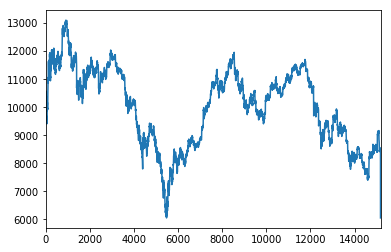

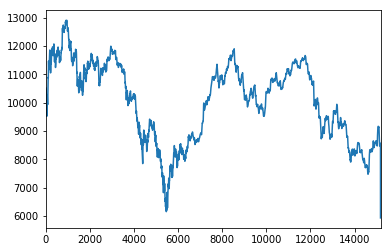

In [126]:

sns.tsplot(original)
plt.show()
sns.tsplot(predicted)
plt.show()

In [127]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true + 1e-10 - y_pred) / y_true + 1e-10)) * 100

In [128]:
mape(original, predicted)

0.6945671864929875

In [129]:
pred_df = pd.DataFrame(predicted)

In [131]:
pred_df.to_csv('./predictions/bitcoin-lstm.csv')

In [141]:
pred_df['original'] = original
pred_df = pred_df.rename(index=str, columns={0: 'Predicted', 'original': 'Original'})

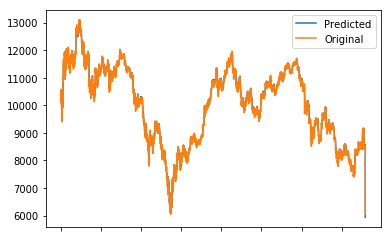

In [142]:
pred_df.plot()